# Data augmentation on the mnist roman dataset for Data-Centric competition

## Refer to https://worksheets.codalab.org/worksheets/0x7a8721f11e61436e93ac8f76da83f0e6

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys

import PIL
import PIL.Image
import pathlib

In [2]:
print(tf.__version__)

2.5.0


In [7]:
data_dir = 'label_book'

In [10]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))
print(f'The foleder {data_dir} contains {image_count} pictures of roman numbers')

The foleder label_book contains 52 pictures of roman numbers


Let's visualize one roman number as example.

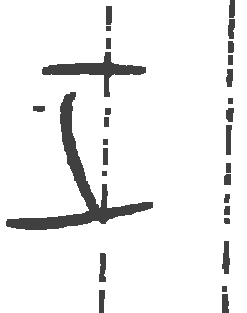

In [12]:
roman_i = list(data_dir.glob('i/*'))
PIL.Image.open(str(roman_i[0]))

Let's ingest the roman numbers by image_dataset_from_directory. The labels will be inferred by the 'class_names' parameter.

In [17]:
roman_numbers = "label_book"

batch_size = 8
tf.random.set_seed(123)

In [20]:
numbers_ds = tf.keras.preprocessing.image_dataset_from_directory(
    roman_numbers,
    labels="inferred",
    label_mode="categorical",
    class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
    shuffle=True,
    seed=123,
    batch_size=batch_size,
    image_size=(32, 32),
)

Found 52 files belonging to 10 classes.


In [22]:
class_names = numbers_ds.class_names
print(f"The class names are {class_names}")

The class names are ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']


In [25]:
for image_batch, labels_batch in numbers_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(8, 32, 32, 3)
(8, 10)


## Visualize the data

Here are the first 9 images from the training dataset.

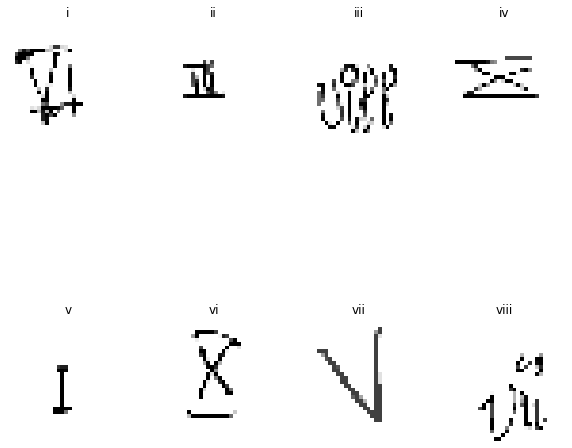

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in numbers_ds.take(1):
  for i in range(batch_size):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

## Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using the tf.keras.layers.experimental.preprocessing.Rescaling layer.

In [35]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

You can apply it to the dataset by calling map:

In [50]:
normalized_ds = numbers_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
#print(type(image_batch), type(labels_batch))
print(image_batch.shape)
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print("min and max value for image 0", np.min(first_image), np.max(first_image))

(8, 32, 32, 3)
min and max value for image 0 0.0 1.0
